<a href="https://colab.research.google.com/github/smartgeometry-ucl/COMP0169-Machine-Learning-for-Visual-Computing-2021/blob/master/TA_motivation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Imports

In [4]:
# Lets import some libraries 
import torch # PyTorch 
from torch.autograd import Variable
from torch.optim import Adam
from torchvision import datasets # Datasets module 
from torchvision import transforms # Image Transforms 
from torchvision import models as pretrained_models # Pretrained models
import torch.nn.functional as F

import numpy as np
import cv2

from matplotlib import pyplot as plt
%matplotlib inline

##### Code to load custom image

In [37]:
def load_custom_image(path):
    """
    Load image from path

    Return a Pytorch image tensor
    """

    img = cv2.imread(path)
    
    # BGR to RGB
    img = img[:, :, [2,1,0]]
    
    # Create a pytorch tensor from numpy
    img_pt = torch.from_numpy(img).float()
    
    # Add an extra 'batch' dimesion by unsqueeze
    # Convert the [B,H,W,3] image to [B,3,H,W]
    # These are necessary to feed image to pytorch networks
    img_pt = img_pt.unsqueeze(0).permute(0, 3, 1, 2)
    
    return img_pt

# Example 1
Classification

In [38]:
def test(test_loader, model, classes,scale=1):
    """
    This function will be used to predict using the trained neural network
    'model', and evaluate classification accuracy and show example images
    that are classified.

    Arguments:
    test_loader : Pytorch data loader. We iterate over this to obtain samples
    model : The neural network model object
    classes : The names of the classes
    """

    # Move model to GPU
    model = model.cuda()

    # No gradients, since we're evaluating and not training
    with torch.no_grad():
        model.eval()
        correct = 0

        # Iterate over the dataset
        for data, target in test_loader:
            # Data and its corresponding labels
            data, target = data.cuda(), target.cuda()
            
            # Predicted labels, using the model
            predictions = model(data)

            # Evaluate accuracy by comparing prediction to target
            predictions_index = predictions.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += predictions_index.eq(target.view_as(predictions_index)).long().cpu().sum()

    print('\nTest set accuracy: {}/{} ({:.0f}%)\n'.format(correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # We have prediction indices, now print the label names using those 
    for p in predictions_index:
        print(classes[p])

    plt.figure()
    for i in range(data.size(0)):
        if data[i].size(0) == 3:
            pred = torch.unsqueeze(data[i].cpu(),0)
            resized = F.interpolate(pred,scale_factor=scale,mode='bicubic')
            plt.imshow(resized[0].permute(1,2,0))
        else:
            plt.imshow(data[i].permute(1,2,0).cpu().squeeze(), cmap='gray')
        plt.show()

#### MNIST example

In [44]:
"""
Load the MNIST dataset. Pytorch has some datasets in the library, MNIST is one 
of them
"""

mnist_data = datasets.MNIST('../data', train=False, 
                    download=True, 
                    # The transform is applied to each image
                    transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(mean=[0.1307], std=[0.3081])
                   ])
                )

# Initializing the torch data loader using the dataset
mnist_test_loader = torch.utils.data.DataLoader(mnist_data,
                                          batch_size=5,
                                          shuffle=False)

# Class ids
classes = list(range(0,10))

In [24]:
alexnet = pretrained_models.alexnet()
alexnet.features[0] = torch.nn.Conv2d(1,64, kernel_size=3)
alexnet.classifier[6] = torch.nn.Linear(4096,10)
!wget "https://www.dropbox.com/s/g3wol62g3s9wdjk/mnist_net.pth?dl=1" -O 'mnist_net.pth'
alexnet.load_state_dict(torch.load('mnist_net.pth'))

--2021-10-12 15:20:26--  https://www.dropbox.com/s/g3wol62g3s9wdjk/mnist_net.pth?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/g3wol62g3s9wdjk/mnist_net.pth [following]
--2021-10-12 15:20:26--  https://www.dropbox.com/s/dl/g3wol62g3s9wdjk/mnist_net.pth
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5bedffa89e3becb355b61cdfbf.dl.dropboxusercontent.com/cd/0/get/BX4P6EpxxczDPqA_nm9FEI6jza7oPfk_8JwyfPO4byGYERPk3fZweCQRkW6Ef7HRPDIEznWATtxbqinx5WlTvBTzsCLXuVWh11aoyAsepY5u3vGIgW6VkkANEf1GI1jnS5T0hP2pe-ShbM9Pxw1fv5Pf/file?dl=1# [following]
--2021-10-12 15:20:27--  https://uc5bedffa89e3becb355b61cdfbf.dl.dropboxusercontent.com/cd/0/get/BX4P6EpxxczDPqA_nm9FEI6jza7oPfk_8JwyfPO4byGYERPk3fZweCQRkW6Ef7HRPDIEznWATtxbqinx5WlTv

<All keys matched successfully>

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Test set accuracy: 9880/10000 (99%)

2
3
4
5
6


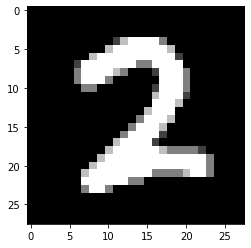

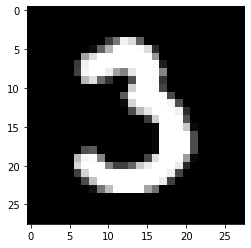

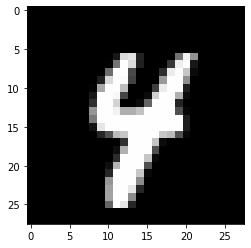

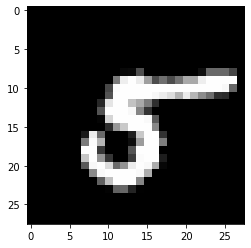

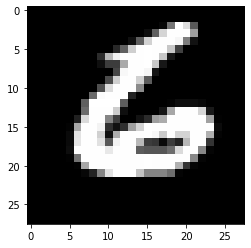

In [13]:
# test model
test(mnist_test_loader, alexnet, classes)

#### CIFAR10 example



In [49]:
# load the data
cifar_data = datasets.CIFAR10('../data', train=False, 
                    download=True,  
                    transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                            std=[0.229, 0.224, 0.225])
                   ])
                )
cifar_test_loader = torch.utils.data.DataLoader(cifar_data,
                                          batch_size=5,
                                          shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [50]:
vgg16 = pretrained_models.vgg16()
vgg16.classifier[6] = torch.nn.Linear(4096,10)
!wget "https://www.dropbox.com/s/0rye71o7gngzgwa/cifar10_net.pth?dl=1" -O 'cifar10_net.pth'
vgg16.load_state_dict(torch.load('cifar10_net.pth'))

--2021-10-12 15:38:41--  https://www.dropbox.com/s/0rye71o7gngzgwa/cifar10_net.pth?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/0rye71o7gngzgwa/cifar10_net.pth [following]
--2021-10-12 15:38:41--  https://www.dropbox.com/s/dl/0rye71o7gngzgwa/cifar10_net.pth
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf6fe44a060eced0cf91a21a1df.dl.dropboxusercontent.com/cd/0/get/BX5Jb8JqTDAvfSVj3ga784U2ZiPlcOCvjX8uuy-gBXmh_194wR2jtgFTBVjfMLZyMHyRn6qMOq8Ptg2gbuX7xK63AWh0XZCwyThib8LMB61iVxXXGbJpiCdnqRR3YgugZQPFYDUJQFIqz9ONHcoX31x8/file?dl=1# [following]
--2021-10-12 15:38:41--  https://ucf6fe44a060eced0cf91a21a1df.dl.dropboxusercontent.com/cd/0/get/BX5Jb8JqTDAvfSVj3ga784U2ZiPlcOCvjX8uuy-gBXmh_194wR2jtgFTBVjfMLZyMHyRn6qMOq8Ptg2

<All keys matched successfully>

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Test set accuracy: 8493/10000 (85%)

ship
cat
dog
car
horse


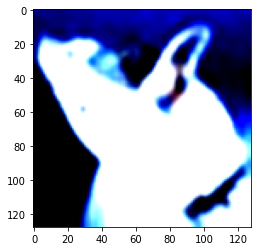

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


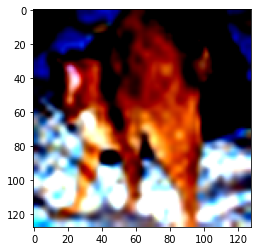

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


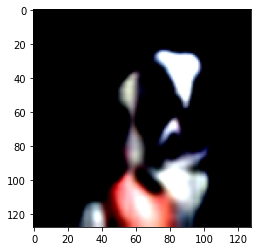

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


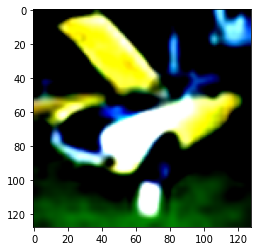

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


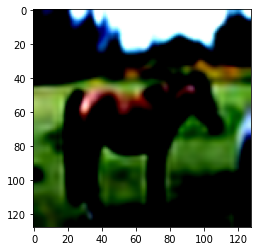

In [51]:
# test model
test(cifar_test_loader, vgg16, classes)

Check [HERE](https://pytorch.org/vision/stable/models.html#classification) to see what other model you can test

# Example 2
Object detection

In [52]:
!wget http://images.cocodataset.org/zips/val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip val2017.zip
!unzip annotations_trainval2017.zip

Streaming output truncated to the last 5000 lines.
 extracting: val2017/000000320425.jpg  
 extracting: val2017/000000481404.jpg  
 extracting: val2017/000000314294.jpg  
 extracting: val2017/000000335328.jpg  
 extracting: val2017/000000513688.jpg  
 extracting: val2017/000000158548.jpg  
 extracting: val2017/000000132116.jpg  
 extracting: val2017/000000415238.jpg  
 extracting: val2017/000000321333.jpg  
 extracting: val2017/000000081738.jpg  
 extracting: val2017/000000577584.jpg  
 extracting: val2017/000000346905.jpg  
 extracting: val2017/000000433980.jpg  
 extracting: val2017/000000228144.jpg  
 extracting: val2017/000000041872.jpg  
 extracting: val2017/000000117492.jpg  
 extracting: val2017/000000368900.jpg  
 extracting: val2017/000000376900.jpg  
 extracting: val2017/000000352491.jpg  
 extracting: val2017/000000330790.jpg  
 extracting: val2017/000000384850.jpg  
 extracting: val2017/000000032735.jpg  
 extracting: val2017/000000197004.jpg  
 extracting: val2017/00000052

In [17]:
category_data = [{"supercategory": "person","id": 1,"name": "person"},{"supercategory": "vehicle","id": 2,"name": "bicycle"},{"supercategory": "vehicle","id": 3,"name": "car"},{"supercategory": "vehicle","id": 4,"name": "motorcycle"},{"supercategory": "vehicle","id": 5,"name": "airplane"},{"supercategory": "vehicle","id": 6,"name": "bus"},{"supercategory": "vehicle","id": 7,"name": "train"},{"supercategory": "vehicle","id": 8,"name": "truck"},{"supercategory": "vehicle","id": 9,"name": "boat"},{"supercategory": "outdoor","id": 10,"name": "traffic light"},{"supercategory": "outdoor","id": 11,"name": "fire hydrant"},{"supercategory": "outdoor","id": 13,"name": "stop sign"},{"supercategory": "outdoor","id": 14,"name": "parking meter"},{"supercategory": "outdoor","id": 15,"name": "bench"},{"supercategory": "animal","id": 16,"name": "bird"},{"supercategory": "animal","id": 17,"name": "cat"},{"supercategory": "animal","id": 18,"name": "dog"},{"supercategory": "animal","id": 19,"name": "horse"},{"supercategory": "animal","id": 20,"name": "sheep"},{"supercategory": "animal","id": 21,"name": "cow"},{"supercategory": "animal","id": 22,"name": "elephant"},{"supercategory": "animal","id": 23,"name": "bear"},{"supercategory": "animal","id": 24,"name": "zebra"},{"supercategory": "animal","id": 25,"name": "giraffe"},{"supercategory": "accessory","id": 27,"name": "backpack"},{"supercategory": "accessory","id": 28,"name": "umbrella"},{"supercategory": "accessory","id": 31,"name": "handbag"},{"supercategory": "accessory","id": 32,"name": "tie"},{"supercategory": "accessory","id": 33,"name": "suitcase"},{"supercategory": "sports","id": 34,"name": "frisbee"},{"supercategory": "sports","id": 35,"name": "skis"},{"supercategory": "sports","id": 36,"name": "snowboard"},{"supercategory": "sports","id": 37,"name": "sports ball"},{"supercategory": "sports","id": 38,"name": "kite"},{"supercategory": "sports","id": 39,"name": "baseball bat"},{"supercategory": "sports","id": 40,"name": "baseball glove"},{"supercategory": "sports","id": 41,"name": "skateboard"},{"supercategory": "sports","id": 42,"name": "surfboard"},{"supercategory": "sports","id": 43,"name": "tennis racket"},{"supercategory": "kitchen","id": 44,"name": "bottle"},{"supercategory": "kitchen","id": 46,"name": "wine glass"},{"supercategory": "kitchen","id": 47,"name": "cup"},{"supercategory": "kitchen","id": 48,"name": "fork"},{"supercategory": "kitchen","id": 49,"name": "knife"},{"supercategory": "kitchen","id": 50,"name": "spoon"},{"supercategory": "kitchen","id": 51,"name": "bowl"},{"supercategory": "food","id": 52,"name": "banana"},{"supercategory": "food","id": 53,"name": "apple"},{"supercategory": "food","id": 54,"name": "sandwich"},{"supercategory": "food","id": 55,"name": "orange"},{"supercategory": "food","id": 56,"name": "broccoli"},{"supercategory": "food","id": 57,"name": "carrot"},{"supercategory": "food","id": 58,"name": "hot dog"},{"supercategory": "food","id": 59,"name": "pizza"},{"supercategory": "food","id": 60,"name": "donut"},{"supercategory": "food","id": 61,"name": "cake"},{"supercategory": "furniture","id": 62,"name": "chair"},{"supercategory": "furniture","id": 63,"name": "couch"},{"supercategory": "furniture","id": 64,"name": "potted plant"},{"supercategory": "furniture","id": 65,"name": "bed"},{"supercategory": "furniture","id": 67,"name": "dining table"},{"supercategory": "furniture","id": 70,"name": "toilet"},{"supercategory": "electronic","id": 72,"name": "tv"},{"supercategory": "electronic","id": 73,"name": "laptop"},{"supercategory": "electronic","id": 74,"name": "mouse"},{"supercategory": "electronic","id": 75,"name": "remote"},{"supercategory": "electronic","id": 76,"name": "keyboard"},{"supercategory": "electronic","id": 77,"name": "cell phone"},{"supercategory": "appliance","id": 78,"name": "microwave"},{"supercategory": "appliance","id": 79,"name": "oven"},{"supercategory": "appliance","id": 80,"name": "toaster"},{"supercategory": "appliance","id": 81,"name": "sink"},{"supercategory": "appliance","id": 82,"name": "refrigerator"},{"supercategory": "indoor","id": 84,"name": "book"},{"supercategory": "indoor","id": 85,"name": "clock"},{"supercategory": "indoor","id": 86,"name": "vase"},{"supercategory": "indoor","id": 87,"name": "scissors"},{"supercategory": "indoor","id": 88,"name": "teddy bear"},{"supercategory": "indoor","id": 89,"name": "hair drier"},{"supercategory": "indoor","id": 90,"name": "toothbrush"}]

classid_to_name = {}


for data_dict in category_data:
  id_number = data_dict['id']
  name = data_dict['name']
  classid_to_name[id_number] = name

max_id = max(classid_to_name.keys())

In [11]:
# use our dataset and defined transformations
dataset_test = datasets.CocoDetection('./val2017','./annotations/instances_val2017.json', transform=transforms.Compose([transforms.ToTensor()]))

data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=4)


loading annotations into memory...
Done (t=0.65s)
creating index...
index created!


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [12]:
# load a model pre-trained on COCO
fasterRCNN = pretrained_models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [13]:
image, labels = next(iter(data_loader_test))
image = image.cuda()
model = fasterRCNN.cuda()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


NameError: ignored

[INFO] chair: 99.66%
[INFO] chair: 99.20%
[INFO] tv: 99.20%
[INFO] potted plant: 98.45%
[INFO] person: 98.38%
[INFO] clock: 96.86%
[INFO] vase: 95.73%
[INFO] vase: 95.71%
[INFO] dining table: 94.85%
[INFO] chair: 92.93%
[INFO] potted plant: 91.11%


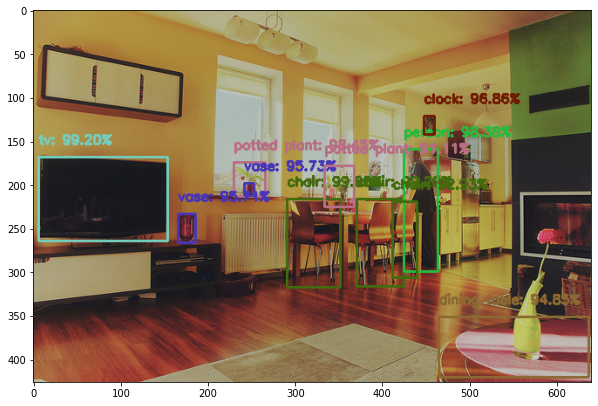

In [20]:
model = model.eval()
detections = model(image)[0]


COLORS = np.random.uniform(0, 1, size=(max_id, 3))

orig = image.squeeze().cpu().numpy().transpose(1,2,0).copy()

# loop over the detections
for i in range(0, len(detections["boxes"])):
	# extract the confidence (i.e., probability) associated with the
	# prediction
	confidence = detections["scores"][i]
	if confidence > 0.9:
		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		# extract the index of the class label from the detections,
		# then compute the (x, y)-coordinates of the bounding box
		# for the object
		idx = int(detections["labels"][i])
		box = detections["boxes"][i].detach().cpu().numpy()
		(startX, startY, endX, endY) = box.astype("int")
		# display the prediction to our terminal
		label = "{}: {:.2f}%".format(classid_to_name[idx], confidence * 100)
		print("[INFO] {}".format(label))
		# draw the bounding box and label on the image
		cv2.rectangle(orig, (startX, startY), (endX, endY),
			COLORS[idx], 2)
		y = startY - 15 if startY - 15 > 15 else startY + 15
		cv2.putText(orig, label, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[idx], 2)
  
# show the output image
plt.figure(figsize=(10,10))
plt.imshow(orig)

# Example 3
Visualize NN activations pattern

In [21]:
vgg16 = pretrained_models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [22]:
def plot_image(img):
    img = img.detach().squeeze().permute(1,2,0)

    # mean and std list for channels (Imagenet)
    mean = torch.tensor([0.485, 0.456, 0.406]).float().reshape(1,1,3)
    std = torch.tensor([0.229, 0.224, 0.225]).float().reshape(1,1,3)

    img *= std
    img += mean
    img = torch.clamp(img, 0.0, 1.0)
    
    np_image = img.cpu().numpy()
    plt.figure()
    plt.imshow(np_image)
    plt.show()

In [23]:
def visualize_cnn_filters(model, cnn_layer, selected_filter):
    model.eval()
    model = model.cuda()

    # Generate a random image
    random_image = torch.rand([1,3,224,224])
    random_image = Variable(random_image, requires_grad=True)

    # Define optimizer for the image
    optimizer = Adam([random_image], lr=0.1, weight_decay=1e-6)

    for i in range(1, 100):

        optimizer.zero_grad()
    
        # Assign create image to a variable to move forward in the model
        x = random_image.cuda()
    
        for index, layer in enumerate(model):
            # Forward pass layer by layer
            # x is not used after this point because it is only needed to trigger
            # the forward hook function
            x = layer(x)
            # Only need to forward until the selected layer is reached
            if index == cnn_layer:
                # (forward hook function triggered)
                break

        filter_output = x[0, selected_filter]

        # Loss function is the mean of the output of the selected layer/filter
        # We try to minimize the mean of the output of that specific filter
        loss = -torch.mean(filter_output)
        # print('Iteration:', str(i), 'Loss:', "{0:.2f}".format(loss.detach().item()))
        # Backward
        loss.backward()
        
        # Update image
        optimizer.step()
    

    plot_image(random_image)

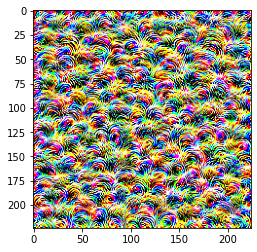

In [24]:
cnn_layer = 17
filter_pos = 5
visualize_cnn_filters(vgg16.features, cnn_layer, filter_pos)

What are patterns are recognized by other filter ? Try to change the 'cnn_layer' and 'filter_pos' variable below.

# Example 4
Visualize which piece of image activates neurons

In [27]:
!wget https://raw.githubusercontent.com/utkuozbulak/pytorch-cnn-visualizations/master/input_images/spider.png 'spider.png'

--2021-10-12 16:55:24--  https://raw.githubusercontent.com/utkuozbulak/pytorch-cnn-visualizations/master/input_images/spider.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52339 (51K) [image/png]
Saving to: ‘spider.png.1’

spider.png.1        100%[===================>]  51.11K  --.-KB/s    in 0.01s   

2021-10-12 16:55:24 (5.04 MB/s) - ‘spider.png.1’ saved [52339/52339]

--2021-10-12 16:55:24--  http://spider.png/
Resolving spider.png (spider.png)... failed: Name or service not known.
wget: unable to resolve host address ‘spider.png’
FINISHED --2021-10-12 16:55:24--
Total wall clock time: 0.1s
Downloaded: 1 files, 51K in 0.01s (5.04 MB/s)


In [36]:
image = load_custom_image('spider.png')

(224, 224, 3)
(224, 224, 3)
torch.Size([224, 224, 3])
torch.Size([1, 3, 224, 224])


In [31]:
def visualize_cnn_filters(model, input_image, cnn_layer, selected_filter):
    model.eval()
    model = model.cuda()
    input_image = input_image.cuda()

    model.zero_grad()
    # Forward pass
    x = input_image
    for index, layer in enumerate(model.features):
        # Forward pass layer by layer
        # x is not used after this point because it is only needed to trigger
        # the forward hook function
        x = layer(x)
        # Only need to forward until the selected layer is reached
        if index == cnn_layer:
            # (forward hook function triggered)
            break


    scale = input_image.size(-1)/x.size(-1)
    return torch.nn.functional.upsample(x, scale_factor=scale, mode='bilinear')[0, filter_pos].detach().cpu().numpy()


In [32]:
vgg16 = pretrained_models.vgg16(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


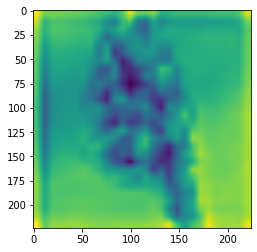

In [34]:
cnn_layer = 17
filter_pos = 5

activations = visualize_cnn_filters(vgg16, image.cuda(), cnn_layer, filter_pos)

plt.figure()
plt.imshow(activations)
plt.show()
